In [1]:
import sys
sys.path.insert(0, '/home/tim/Classes/CS535/PlanarGrasping/')
# sys.path.insert(0, '/home/tim/Classes/CS535/PlanarGrasping/network/')

import pickle
import matplotlib.pyplot as plt

from network.model import net, data_loader
from network import utils
import numpy as np

from IPython import display
%matplotlib inline

import torch

import torch.optim as optim

In [2]:
json_path = '/home/tim/Classes/CS535/PlanarGrasping/network/experiments/sdf_cnn/params.json'
params = utils.Params(json_path)
params.cuda = torch.cuda.is_available()

data_dir = '/home/tim/Classes/CS535/PlanarGrasping/network/data'

# fetch dataset
ds = data_loader.SDFDataset('/home/tim/Classes/CS535/PlanarGrasping/network/data/val')

# Define the model and optimizer
model = net.Net(params).cuda()
optimizer = optim.Adam(model.parameters(), lr=params.learning_rate)

model.eval()

# # reload weights from restore_file if specified
weight_file = '/home/tim/Classes/CS535/PlanarGrasping/network/experiments/sdf_cnn/best.pth.tar'
_ = utils.load_checkpoint(weight_file, model, optimizer)


Opening Dataset from /home/tim/Classes/CS535/PlanarGrasping/network/data/val/val_examples.p


In [3]:
import pickle
examples = pickle.load(open('/home/tim/Classes/CS535/PlanarGrasping/network/data/val/val_examples.p', 'rb'))

0
-0.19925788


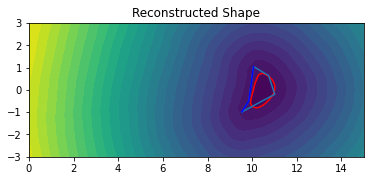

1000
-0.14130272


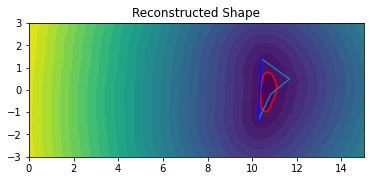

2000
-0.15293677


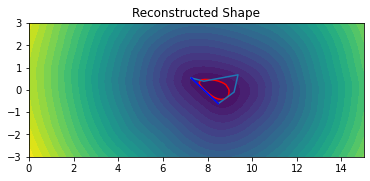

3000
-0.23657583


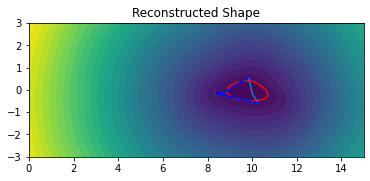

4000
-0.20157246


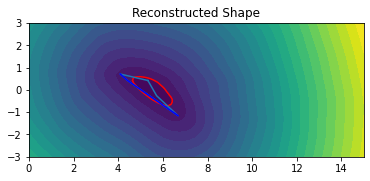

5000
-0.3414017


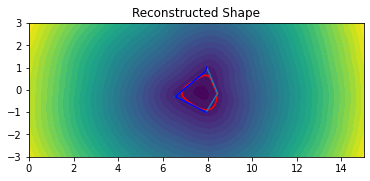

6000
-0.13050705


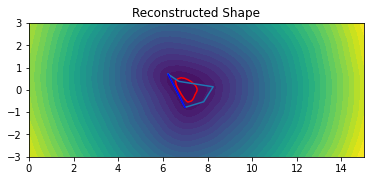

7000
-0.1832555


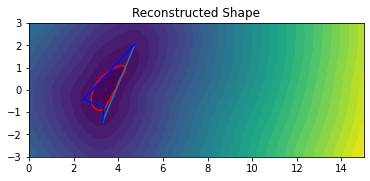

8000
-0.23700452


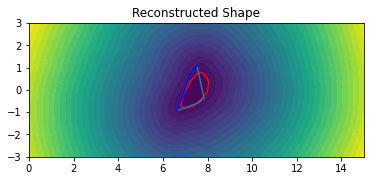

9000


KeyboardInterrupt: 

In [13]:
for i in range(0,len(ds),1000):
    train_batch, labels_batch = ds[i]
    print(i)

    scan_pts = train_batch[:-1,:]

    for ex in examples:
        if np.array_equal(ex[0], scan_pts):
            te = ex[6]
            break
    bounds = [0, 15, -3, 3]
    xs = np.linspace(*bounds[:2], 100)
    ys = np.linspace(*bounds[2:], 100)
    X, Y = np.meshgrid(xs, ys)
    pts = np.column_stack([
        X.ravel(),
        Y.ravel()
    ])

    dists = []
    for pt in pts:
        inp = np.vstack([scan_pts, pt])
        inp = torch.Tensor(inp).contiguous()
        s = torch.Tensor(inp).cuda()
        z = model.forward(s).cpu().detach().numpy()
        dists.append(z)

    fig, ax = plt.subplots()
    ax.tricontourf(X.ravel(), Y.ravel(), dists, levels=30, cmap="viridis")
    ax.tricontour(X.ravel(), Y.ravel(), dists, levels=[0], colors='r')

    from data_generation.utils import plot_shape
    from data_generation.training_ex import glob_to_loc
    from shapely.geometry import Polygon

    coords = np.array(te.shape.exterior.coords)

    tf_shape = Polygon(glob_to_loc(coords, te.robang, te.robx, te.roby))
    # tf_shape = translate(rotate(te.shape, te.robang), te.robx, te.roby)
    plot_shape(tf_shape, ax, bounds=bounds, title="Reconstructed Shape")
    ax.plot(scan_pts[:,0], scan_pts[:,1], 'b')
    plt.pause(0.01)

In [49]:
for i, (train_batch, labels_batch) in enumerate(val_dl):
    scan_pts = train_batch[0][:-1,:].numpy()
    query_pt = train_batch[0][-1,:].numpy()
    print(query_pt)
    print(labels_batch[0])
    print(model.forward(train_batch[0].float().cuda()))
    break

[12.70627143  2.04551195]
tensor(2.6959, dtype=torch.float64)
tensor(0.6596, device='cuda:0', grad_fn=<SqueezeBackward0>)
